In [1]:
import cv2
from PIL import Image
import imageio
from tqdm import tqdm

import torch
import torch.nn.init
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import json
import matplotlib

import matplotlib.pyplot as plt
import numpy as np
import time

import util
import NeuralNets as NN
import dataset



In [2]:
LEARNING_RATE =  0.001
PRE_EPOCHS = 16
EPOCHS = 64
BATCH_SIZE = 2

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)

if device == 'cuda':
    torch.cuda.manual_seed_all(777)


In [4]:
PRE_TRAIN_PATH = "./coco_data/train_2017/img/"
PRE_LABEL_PATH = "./coco_data/train_2017/label.json"

TRAIN_PATH = "./second_train_data/img/"
LABEL_PATH = "./second_train_data/label.json"

In [5]:
class FocusDataset(Dataset):
    def __init__(self, path, label_path, transform=None):
        self.x_datas = []
        self.y_datas = {}
        self.path = path
        self.transform = transform

        fileDir = os.listdir(path)
        for file in fileDir:
            self.x_datas.append(file)
        
        file = open(label_path, 'r')
        c = json.load(file)
        for each in c:
            self.y_datas[each["img_path"]] = each["focus_point"]

    def __len__(self):
        return len(self.x_datas)

    def __getitem__(self, idx):
        target = self.x_datas[idx]
        
        x = Image.open(self.path + target).convert("RGB")

        ori_shape = x.size
        y = self.y_datas[target]
        y = util.point_adjust(y, ori_shape, NN.INPUT_SHAPE)
        y = util.pointMap(y)

        if self.transform:
            x = util.transform(x, y)

        x = x.resize(NN.INPUT_SHAPE)
        x = np.array(x)
        return x , y


preTrainDataset = FocusDataset(PRE_TRAIN_PATH, PRE_LABEL_PATH)
trainDataset = FocusDataset(TRAIN_PATH, LABEL_PATH)


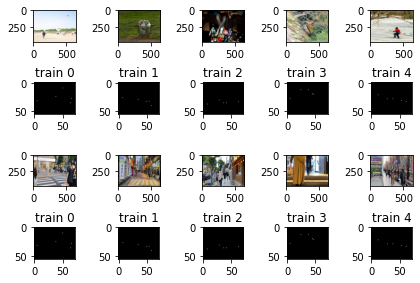

In [6]:
import random

fig, ax = plt.subplots(4, 5)


for i in range(5):
    randId = int(random.random() * len(trainDataset))
    preTrainData = preTrainDataset[randId]
    trainData = trainDataset[randId]


    preImg = preTrainData[0]
    preFocus = preTrainData[1]
    img = trainData[0]
    focus = trainData[1]

    ax[0, i].imshow(preImg)
    ax[1, i].imshow(focus, cmap='gray')
    #ax[1, i].scatter(preFocus[:, 0], preFocus[:, 1], marker="o", color='green')
    ax[1, i].set_title("train {}".format(i))
    
    ax[2, i].imshow(img)
    ax[3, i].imshow(focus, cmap='gray')
    #ax[3, i].scatter(focus[:, 0], focus[:, 1], marker="o", color='green')
    ax[3, i].set_title("train {}".format(i))


plt.tight_layout()
plt.show()

In [7]:
pre_train_loader =  DataLoader(dataset = preTrainDataset, batch_size=BATCH_SIZE, shuffle=True )
train_loader =  DataLoader(dataset = trainDataset, batch_size=BATCH_SIZE, shuffle=True )

In [8]:
model = NN.FocusNN3()
model = torch.nn.DataParallel(model)
model.to(device)

criterion = torch.nn.MSELoss().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

print(model)

import torchsummary
torchsummary.torchsummary.summary(model, batch_size=BATCH_SIZE,device=device,input_size=(3, 480, 640))


DataParallel(
  (module): FocusNN3(
    (size_down_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (reduce_features): ModuleList(
      (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    )
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Bottleneck(
        (conv1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(64, eps=1e-05, 

C:\Users\yunmi\anaconda3\envs\torch-env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1           [2, 3, 240, 320]               0
         MaxPool2d-2           [2, 3, 120, 160]               0
            Conv2d-3            [2, 64, 59, 79]           4,864
              ReLU-4            [2, 64, 59, 79]               0
            Conv2d-5            [2, 16, 59, 79]           1,024
       BatchNorm2d-6            [2, 16, 59, 79]              32
              ReLU-7            [2, 16, 59, 79]               0
            Conv2d-8            [2, 16, 59, 79]           2,304
       BatchNorm2d-9            [2, 16, 59, 79]              32
             ReLU-10            [2, 16, 59, 79]               0
           Conv2d-11            [2, 64, 59, 79]           1,024
      BatchNorm2d-12            [2, 64, 59, 79]             128
             ReLU-13            [2, 64, 59, 79]               0
       Bottleneck-14            [2, 64,

In [10]:
# PRE TRAIN MODEL
train_losses = []

for singleEpoch in range(1, PRE_EPOCHS):
    startTime = time.time()

    train_loss = 0.0
    total = 0
    model.train()

    tmp = None
    for data, points in tqdm(pre_train_loader, desc="Epoch: {}".format(singleEpoch)):
        data = data.permute(0, 3, 1, 2)
        data = data.cuda().float()

        points = points[None, ...]
        points = points.permute(1, 0, 2, 3)
        points = points.cuda().float()

        # cleaer the gradients all optimized variables
        optimizer.zero_grad()

        # forward process
        out = model(data)
        # backpropagation
        loss = criterion(out, points)
        loss.backward()

        optimizer.step()
        total += BATCH_SIZE
        train_loss += loss.item()
    # calculate average loss
    train_loss = train_loss/total
    train_losses.append(train_loss)

    print('Epoch: {} \tTraining Loss: {:.5f}'.format(singleEpoch, train_loss))

Epoch: 1: 100%|██████████| 498/498 [00:44<00:00, 11.15it/s]


Epoch: 1 	Training Loss: 40.40835


Epoch: 2: 100%|██████████| 498/498 [00:50<00:00,  9.88it/s]


Epoch: 2 	Training Loss: 40.39791


Epoch: 3: 100%|██████████| 498/498 [00:44<00:00, 11.19it/s]


Epoch: 3 	Training Loss: 40.39179


Epoch: 4: 100%|██████████| 498/498 [00:43<00:00, 11.33it/s]


Epoch: 4 	Training Loss: 40.38995


Epoch: 5: 100%|██████████| 498/498 [00:52<00:00,  9.55it/s]


Epoch: 5 	Training Loss: 40.38131


Epoch: 6: 100%|██████████| 498/498 [01:05<00:00,  7.62it/s]


Epoch: 6 	Training Loss: 40.37674


Epoch: 7: 100%|██████████| 498/498 [01:00<00:00,  8.23it/s]


Epoch: 7 	Training Loss: 40.36996


Epoch: 8: 100%|██████████| 498/498 [01:00<00:00,  8.17it/s]


Epoch: 8 	Training Loss: 40.36696


Epoch: 9: 100%|██████████| 498/498 [01:00<00:00,  8.26it/s]


Epoch: 9 	Training Loss: 40.36118


Epoch: 10: 100%|██████████| 498/498 [00:58<00:00,  8.56it/s]


Epoch: 10 	Training Loss: 40.36081


Epoch: 11: 100%|██████████| 498/498 [01:00<00:00,  8.29it/s]


Epoch: 11 	Training Loss: 40.35041


Epoch: 12: 100%|██████████| 498/498 [00:57<00:00,  8.72it/s]


Epoch: 12 	Training Loss: 40.34438


Epoch: 13: 100%|██████████| 498/498 [00:59<00:00,  8.35it/s]


Epoch: 13 	Training Loss: 40.33572


Epoch: 14: 100%|██████████| 498/498 [00:59<00:00,  8.41it/s]


Epoch: 14 	Training Loss: 40.32387


Epoch: 15: 100%|██████████| 498/498 [00:59<00:00,  8.42it/s]

Epoch: 15 	Training Loss: 40.31315


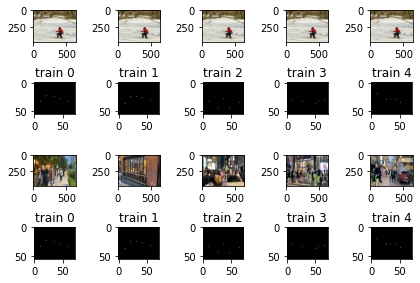

In [11]:

fig, ax = plt.subplots(4, 5)


for i in range(5):
    randId = int(random.random() * len(trainDataset))
    trainData = trainDataset[randId]
    preTrainData = preTrainDataset[randId]
    img = trainData[0]
    pre_img = preTrainData[0]
    focus = trainData[1]
    preFocus = preTrainDataset[1]

    data = torch.tensor(pre_img)
    data = data.permute(2, 0, 1)[None,...]
    data = data.to(device, non_blocking=True).long().float()
    predictions = model(data).cpu().detach().numpy()[0]
    

    data2 = torch.tensor(img)
    data2 = data2.permute(2, 0, 1)[None,...]
    data2 = data2.to(device, non_blocking=True).long().float()
    predictions2 = model(data2).cpu().detach().numpy()[0]

    # predictions = np.argwhere(x > 0.01)





    ax[0, i].imshow(preImg)
    ax[1, i].imshow(focus, cmap='gray')
    ax[1, i].set_title("train {}".format(i))
    
    ax[2, i].imshow(img)
    ax[3, i].imshow(focus, cmap='gray')
    ax[3, i].set_title("train {}".format(i))




plt.tight_layout()
plt.show()

In [12]:
# TRAIN MODEL
train_losses = []

for singleEpoch in range(1, EPOCHS+1):
    startTime = time.time()

    train_loss = 0.0
    total = 0
    model.train()

    tmp = None
    for data, points in tqdm(train_loader, desc="Epoch: {}".format(singleEpoch)):
        data = data.permute(0, 3, 1, 2)
        data = data.cuda().float()
        
        points = points[None, ...]
        points = points.permute(1, 0, 2, 3)
        points = points.cuda().float()

        # cleaer the gradients all optimized variables
        optimizer.zero_grad()

        # forward process
        out = model(data)

        # backpropagation
        loss = criterion(out, points)
        loss.backward()

        optimizer.step()
        total += BATCH_SIZE
        train_loss += loss.item()
    # calculate average loss
    train_loss = train_loss/total
    train_losses.append(train_loss)

    print('Epoch: {} \tTraining Loss: {:.5f}'.format(singleEpoch, train_loss))

Epoch: 1: 100%|██████████| 151/151 [00:13<00:00, 11.13it/s]


Epoch: 1 	Training Loss: 40.50579


Epoch: 2: 100%|██████████| 151/151 [00:11<00:00, 12.85it/s]


Epoch: 2 	Training Loss: 40.46462


Epoch: 3: 100%|██████████| 151/151 [00:18<00:00,  8.26it/s]


Epoch: 3 	Training Loss: 40.43683


Epoch: 4: 100%|██████████| 151/151 [00:20<00:00,  7.46it/s]


Epoch: 4 	Training Loss: 40.40974


Epoch: 5: 100%|██████████| 151/151 [00:17<00:00,  8.81it/s]


Epoch: 5 	Training Loss: 40.36726


Epoch: 6: 100%|██████████| 151/151 [00:17<00:00,  8.85it/s]


Epoch: 6 	Training Loss: 40.31012


Epoch: 7: 100%|██████████| 151/151 [00:16<00:00,  9.09it/s]


Epoch: 7 	Training Loss: 40.27335


Epoch: 8: 100%|██████████| 151/151 [00:16<00:00,  9.27it/s]


Epoch: 8 	Training Loss: 40.23364


Epoch: 9: 100%|██████████| 151/151 [00:16<00:00,  8.92it/s]


Epoch: 9 	Training Loss: 40.19984


Epoch: 10: 100%|██████████| 151/151 [00:16<00:00,  9.13it/s]


Epoch: 10 	Training Loss: 40.15504


Epoch: 11: 100%|██████████| 151/151 [00:18<00:00,  8.07it/s]


Epoch: 11 	Training Loss: 40.13484


Epoch: 12: 100%|██████████| 151/151 [00:16<00:00,  9.23it/s]


Epoch: 12 	Training Loss: 40.11665


Epoch: 13: 100%|██████████| 151/151 [00:16<00:00,  9.24it/s]


Epoch: 13 	Training Loss: 40.09442


Epoch: 14: 100%|██████████| 151/151 [00:16<00:00,  9.29it/s]


Epoch: 14 	Training Loss: 40.08219


Epoch: 15: 100%|██████████| 151/151 [00:16<00:00,  9.27it/s]


Epoch: 15 	Training Loss: 40.07303


Epoch: 16: 100%|██████████| 151/151 [00:16<00:00,  9.01it/s]


Epoch: 16 	Training Loss: 40.06061


Epoch: 17: 100%|██████████| 151/151 [00:17<00:00,  8.43it/s]


Epoch: 17 	Training Loss: 40.05493


Epoch: 18: 100%|██████████| 151/151 [00:16<00:00,  8.91it/s]


Epoch: 18 	Training Loss: 40.05491


Epoch: 19: 100%|██████████| 151/151 [00:16<00:00,  9.28it/s]


Epoch: 19 	Training Loss: 40.08675


Epoch: 20: 100%|██████████| 151/151 [00:16<00:00,  9.02it/s]


Epoch: 20 	Training Loss: 40.05392


Epoch: 21: 100%|██████████| 151/151 [00:16<00:00,  9.02it/s]


Epoch: 21 	Training Loss: 40.04206


Epoch: 22: 100%|██████████| 151/151 [00:17<00:00,  8.76it/s]


Epoch: 22 	Training Loss: 40.03455


Epoch: 23: 100%|██████████| 151/151 [00:16<00:00,  9.24it/s]


Epoch: 23 	Training Loss: 40.03080


Epoch: 24: 100%|██████████| 151/151 [00:16<00:00,  9.04it/s]


Epoch: 24 	Training Loss: 40.02867


Epoch: 25: 100%|██████████| 151/151 [00:16<00:00,  9.01it/s]


Epoch: 25 	Training Loss: 40.02662


Epoch: 26: 100%|██████████| 151/151 [00:16<00:00,  9.14it/s]


Epoch: 26 	Training Loss: 40.02495


Epoch: 27: 100%|██████████| 151/151 [00:17<00:00,  8.78it/s]


Epoch: 27 	Training Loss: 40.02541


Epoch: 28: 100%|██████████| 151/151 [00:17<00:00,  8.81it/s]


Epoch: 28 	Training Loss: 40.02666


Epoch: 29: 100%|██████████| 151/151 [00:17<00:00,  8.77it/s]


Epoch: 29 	Training Loss: 40.02526


Epoch: 30: 100%|██████████| 151/151 [00:17<00:00,  8.87it/s]


Epoch: 30 	Training Loss: 40.02485


Epoch: 31: 100%|██████████| 151/151 [00:17<00:00,  8.85it/s]


Epoch: 31 	Training Loss: 40.02427


Epoch: 32: 100%|██████████| 151/151 [00:18<00:00,  8.39it/s]


Epoch: 32 	Training Loss: 40.02293


Epoch: 33: 100%|██████████| 151/151 [00:18<00:00,  8.03it/s]


Epoch: 33 	Training Loss: 40.02269


Epoch: 34: 100%|██████████| 151/151 [00:17<00:00,  8.78it/s]


Epoch: 34 	Training Loss: 40.02230


Epoch: 35: 100%|██████████| 151/151 [00:17<00:00,  8.71it/s]


Epoch: 35 	Training Loss: 40.02164


Epoch: 36: 100%|██████████| 151/151 [00:16<00:00,  8.91it/s]


Epoch: 36 	Training Loss: 40.02189


Epoch: 37: 100%|██████████| 151/151 [00:17<00:00,  8.62it/s]


Epoch: 37 	Training Loss: 40.02150


Epoch: 38: 100%|██████████| 151/151 [00:17<00:00,  8.60it/s]


Epoch: 38 	Training Loss: 40.02069


Epoch: 39: 100%|██████████| 151/151 [00:17<00:00,  8.51it/s]


Epoch: 39 	Training Loss: 40.01864


Epoch: 40: 100%|██████████| 151/151 [00:16<00:00,  9.06it/s]


Epoch: 40 	Training Loss: 40.01988


Epoch: 41: 100%|██████████| 151/151 [00:17<00:00,  8.75it/s]


Epoch: 41 	Training Loss: 40.01985


Epoch: 42: 100%|██████████| 151/151 [00:19<00:00,  7.72it/s]


Epoch: 42 	Training Loss: 40.04846


Epoch: 43: 100%|██████████| 151/151 [00:18<00:00,  8.27it/s]


Epoch: 43 	Training Loss: 40.03686


Epoch: 44: 100%|██████████| 151/151 [00:17<00:00,  8.81it/s]


Epoch: 44 	Training Loss: 40.02188


Epoch: 45: 100%|██████████| 151/151 [00:18<00:00,  8.35it/s]


Epoch: 45 	Training Loss: 40.01633


Epoch: 46: 100%|██████████| 151/151 [00:18<00:00,  8.32it/s]


Epoch: 46 	Training Loss: 40.01349


Epoch: 47: 100%|██████████| 151/151 [00:18<00:00,  8.18it/s]


Epoch: 47 	Training Loss: 40.01230


Epoch: 48: 100%|██████████| 151/151 [00:16<00:00,  9.40it/s]


Epoch: 48 	Training Loss: 40.01178


Epoch: 49: 100%|██████████| 151/151 [00:16<00:00,  9.12it/s]


Epoch: 49 	Training Loss: 40.01195


Epoch: 50: 100%|██████████| 151/151 [00:16<00:00,  8.98it/s]


Epoch: 50 	Training Loss: 40.01229


Epoch: 51: 100%|██████████| 151/151 [00:17<00:00,  8.81it/s]


Epoch: 51 	Training Loss: 40.01209


Epoch: 52: 100%|██████████| 151/151 [00:16<00:00,  9.14it/s]


Epoch: 52 	Training Loss: 40.01281


Epoch: 53: 100%|██████████| 151/151 [00:16<00:00,  8.89it/s]


Epoch: 53 	Training Loss: 40.01398


Epoch: 54: 100%|██████████| 151/151 [00:16<00:00,  8.95it/s]


Epoch: 54 	Training Loss: 40.01504


Epoch: 55: 100%|██████████| 151/151 [00:16<00:00,  8.94it/s]


Epoch: 55 	Training Loss: 40.01537


Epoch: 56: 100%|██████████| 151/151 [00:16<00:00,  9.13it/s]


Epoch: 56 	Training Loss: 40.01503


Epoch: 57: 100%|██████████| 151/151 [00:18<00:00,  7.98it/s]


Epoch: 57 	Training Loss: 40.01651


Epoch: 58: 100%|██████████| 151/151 [00:16<00:00,  9.38it/s]


Epoch: 58 	Training Loss: 40.01551


Epoch: 59: 100%|██████████| 151/151 [00:16<00:00,  8.92it/s]


Epoch: 59 	Training Loss: 40.01489


Epoch: 60: 100%|██████████| 151/151 [00:17<00:00,  8.76it/s]


Epoch: 60 	Training Loss: 40.01417


Epoch: 61: 100%|██████████| 151/151 [00:18<00:00,  8.03it/s]


Epoch: 61 	Training Loss: 40.01339


Epoch: 62: 100%|██████████| 151/151 [00:16<00:00,  8.97it/s]


Epoch: 62 	Training Loss: 40.01326


Epoch: 63: 100%|██████████| 151/151 [00:16<00:00,  9.19it/s]


Epoch: 63 	Training Loss: 40.01307


Epoch: 64: 100%|██████████| 151/151 [00:17<00:00,  8.62it/s]

Epoch: 64 	Training Loss: 40.01259


In [13]:
torch.save(model.state_dict(), "./weights/model4.ckpt")

2.2108915 -1.7695849
2.8680084 -1.6923485
2.381897 -1.7584227
2.2192671 -2.2524066
1.7980542 -1.8327987


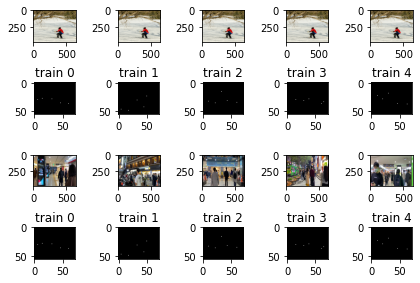

In [15]:

fig, ax = plt.subplots(4, 5)


for i in range(5):
    randId = int(random.random() * len(trainDataset))
    trainData = trainDataset[randId]
    preTrainData = preTrainDataset[randId]
    pre_img = preTrainData[0]
    img = trainData[0]
    preFocus = preTrainDataset[1]
    focus = trainData[1]

    data = torch.tensor(pre_img)
    data = data.permute(2, 0, 1)[None,...]
    data = data.to(device, non_blocking=True).long().float()
    predictions = model(data).cpu().detach().numpy()[0]
    

    data2 = torch.tensor(img)
    data2 = data2.permute(2, 0, 1)[None,...]
    data2 = data2.to(device, non_blocking=True).long().float()
    predictions2 = model(data2).cpu().detach().numpy()[0]
    print(np.max(predictions), np.min(predictions))
    # predictions = np.argwhere(x > 0.01)





    ax[0, i].imshow(preImg)
    ax[1, i].imshow(focus, cmap='gray')
    ax[1, i].set_title("train {}".format(i))
    
    ax[2, i].imshow(img)
    ax[3, i].imshow(focus, cmap='gray')
    ax[3, i].set_title("train {}".format(i))




plt.tight_layout()
plt.show()